In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from utils import *

CONDITION_MAP = {
        1: "Textual Explanations (C1)",
        2: "Visual Explanations (C2)",
        3: "AI CLs (C3)",
        4: "Human Feedback (C4)",
        5: "AI-Driven Questions (C5)",
        6: "Performance Visualization (C6)"
    }

Condition: 1
Condition: 2
Condition: 3
Condition: 4
Condition: 5
Condition: 6


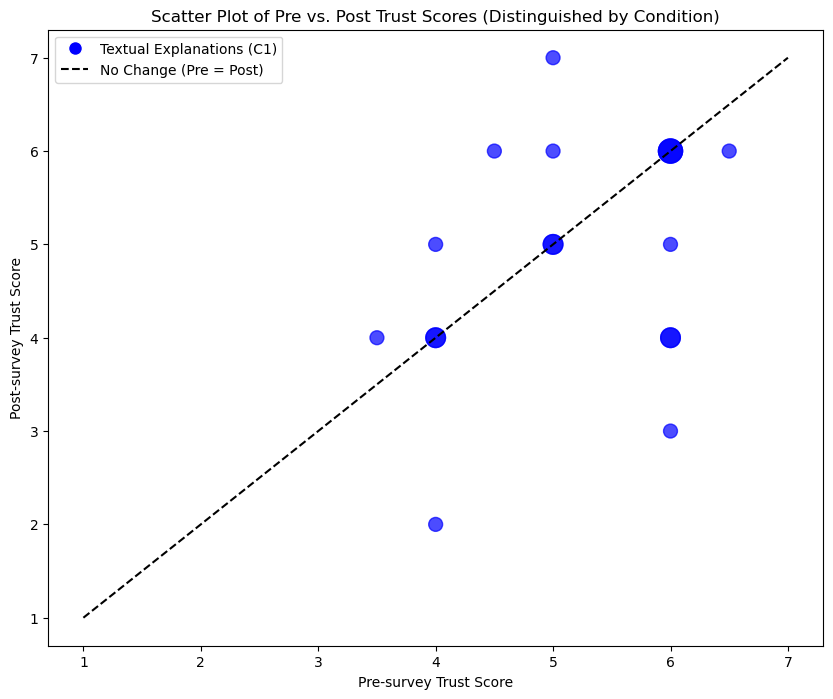

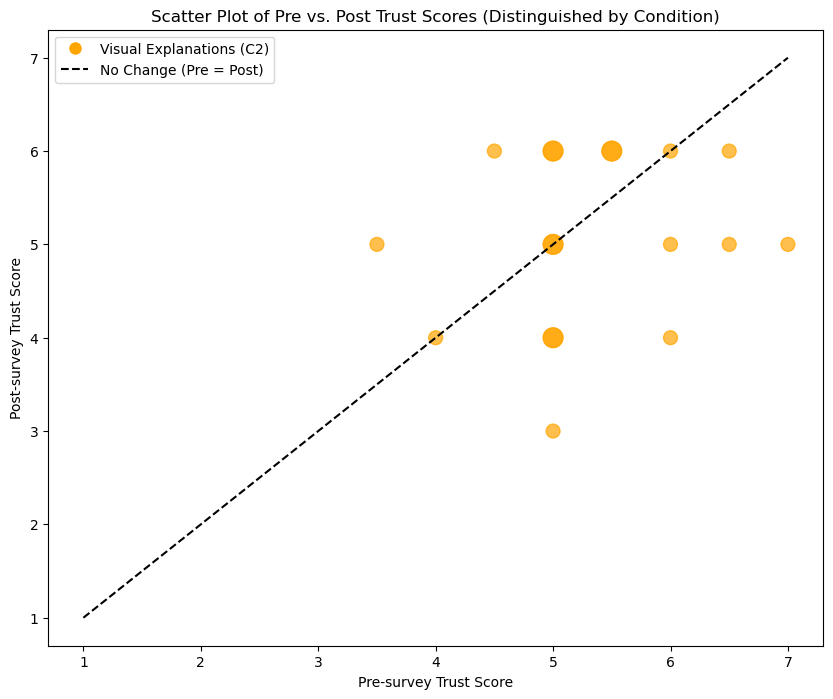

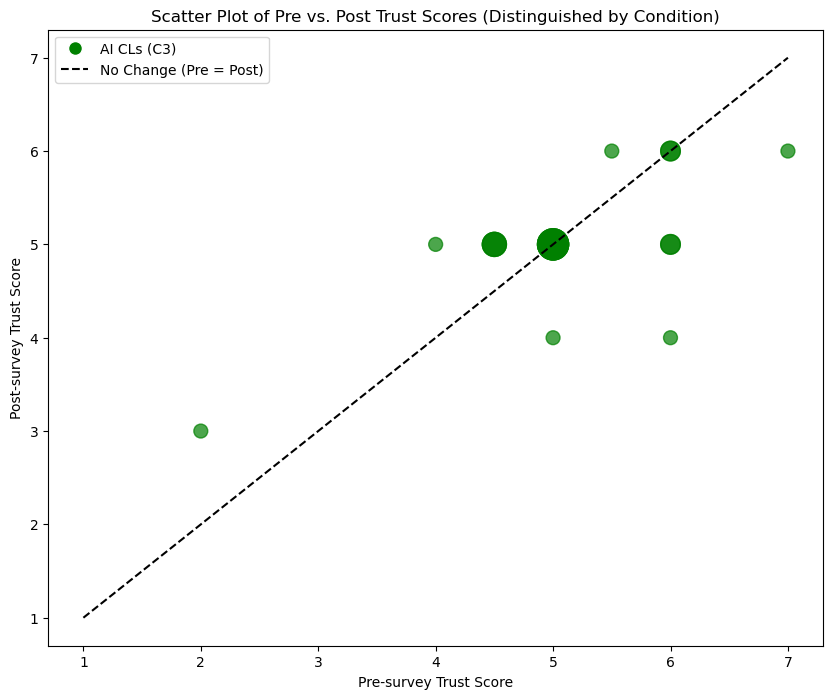

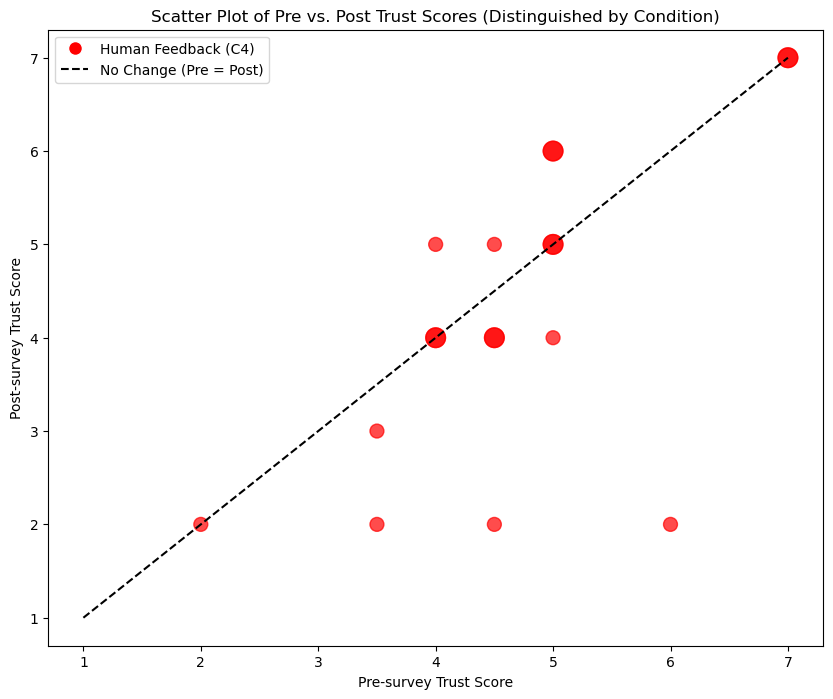

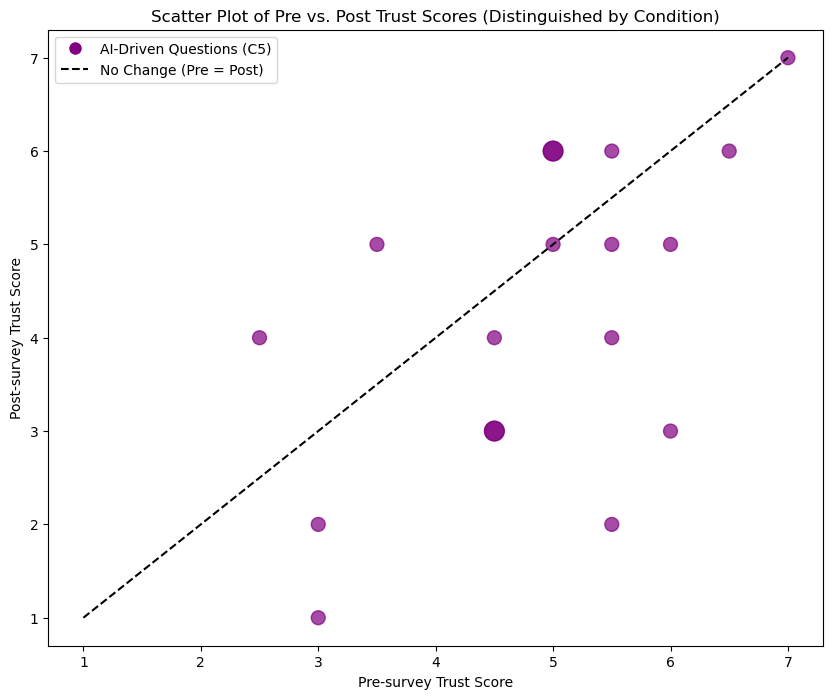

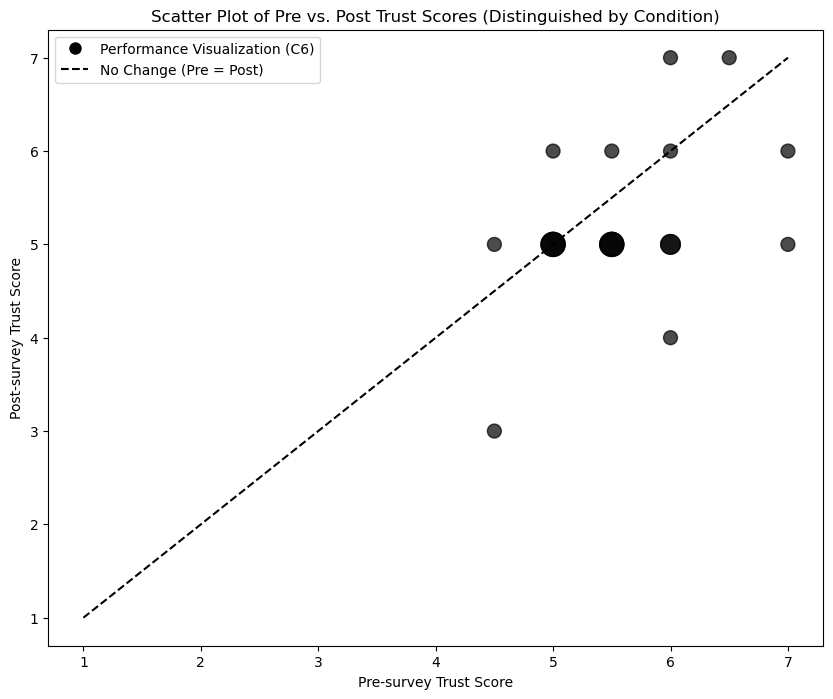

In [2]:
from collections import Counter
from matplotlib.lines import Line2D

df = load_data()

survey = ['trust']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'black'] 

all_scores = np.array([])
for i in range(1, 7):
    temp = df[df['condition'] == i]
    print('Condition: ' + str(i))
    pre_scores = np.array([])
    post_scores = np.array([])
    for index, row in temp.iterrows():
        prescore = (row['pre_trust'] + row['pre_accurate']) / 2
        postscore =  (row['post_trust'])
        pre_scores = np.append(pre_scores, prescore)
        post_scores = np.append(post_scores, postscore)
        all_scores = np.append(all_scores, pre_scores)
        all_scores = np.append(all_scores, post_scores)

    data_pairs = list(zip(pre_scores, post_scores))
    counts = Counter(data_pairs)
    sizes = [counts[point] * 100 for point in data_pairs]  # Scale size (e.g., multiply by 50)

    plt.figure(figsize=(10, 8))
    plt.scatter(pre_scores, post_scores, s=sizes, alpha=0.7, label=f'{CONDITION_MAP[int(i)]}', color=colors[i - 1])
    plt.plot([1,7], [1,7], 
            color='black', linestyle='--', label='No Change (y = x)')
    plt.grid(False)

    # Add labels, legend, and title
    plt.xlabel('Pre-survey Trust Score')
    plt.ylabel('Post-survey Trust Score')
    plt.title('Scatter Plot of Pre vs. Post Trust Scores (Distinguished by Condition)')
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'{CONDITION_MAP[int(i)]}',
               markerfacecolor=colors[i - 1], markersize=10),
        Line2D([0], [0], color='black', linestyle='--', label='No Change (Pre = Post)')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

In [3]:
df = load_data()

low = df[df['familiar_with_diabetes'] <= 4]
high = df[df['familiar_with_diabetes'] > 4]

for i in range(1, 7):
    print(f"Condition {i}")
    low_temp = low[low['condition'] == i]
    high_temp = high[high['condition'] == i]
    low_acc = []
    high_acc = []
    # LOW
    for index, row in low_temp.iterrows():
        total = 0
        correct = 0
        for q in range(1, 21):
            total += 1
            if row[f"{q}_gt"] == row[f"{q}_3"]:
                correct += 1
        low_acc.append(correct / total)
    # HIGH
    for index, row in high_temp.iterrows():
        total = 0
        correct = 0
        for q in range(1, 21):
            total += 1
            if row[f"{q}_gt"] == row[f"{q}_3"]:
                correct += 1
        high_acc.append(correct / total)

    from scipy.stats import mannwhitneyu
    u_stat, p_value = mannwhitneyu(low_acc, high_acc, alternative='two-sided')
    # print("U-statistic:", u_stat)
    print("p-value:", p_value)


Condition 1
p-value: 0.3362192582410559
Condition 2
p-value: 0.8075142680652766
Condition 3
p-value: 0.14522637719102457
Condition 4
p-value: 0.7171750375645046
Condition 5
p-value: 0.2587037463406764
Condition 6
p-value: 0.9629126178105774


In [4]:
# COMPARE WITHIN CONDITIONS

import pandas as pd
from scipy.stats import wilcoxon, kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your data
# Replace 'your_data.csv' with the path to your CSV file
data = load_data()

data['Before_Score'] = (data['pre_trust'] + data['pre_accurate']) / 2
# data['After_Score'] = (data['post_trust'] + data['post_increase_trust'] + data['post_comfortable']) / 3
data['After_Score'] = data['post_trust']

# Compute score changes if not already in the dataset
if 'Score_Change' not in data.columns:
    data['Score_Change'] = data['After_Score'] - data['Before_Score']

# Perform Wilcoxon Signed-Rank Test within each condition
print("Wilcoxon Signed-Rank Test Results:")
for condition in data['condition'].unique():
    subset = data[data['condition'] == condition]
    stat, p = wilcoxon(subset['Before_Score'], subset['After_Score'])
    print(f"Condition {condition}: W={stat}, p={p}")

# Perform Kruskal-Wallis Test across conditions
print("\nKruskal-Wallis Test Result:")
stat, p = kruskal(*[data[data['condition'] == condition]['Score_Change'] for condition in data['condition'].unique()])
print(f"H={stat}, p={p}")

# Post-hoc pairwise comparisons if Kruskal-Wallis is significant
if p < 0.05:
    print("\nPost-Hoc Pairwise Mann-Whitney U Tests:")
    conditions = data['condition'].unique()
    p_values = []
    comparisons = []
    
    for i, cond1 in enumerate(conditions):
        for cond2 in conditions[i + 1:]:
            subset1 = data[data['condition'] == cond1]['Score_Change']
            subset2 = data[data['condition'] == cond2]['Score_Change']
            stat, p = mannwhitneyu(subset1, subset2, alternative='two-sided')
            p_values.append(p)
            comparisons.append(f"{cond1} vs {cond2}")
    
    # Adjust p-values for multiple comparisons
    corrected_p = multipletests(p_values, method='bonferroni')[1]
    
    for comparison, raw_p, adj_p in zip(comparisons, p_values, corrected_p):
        print(f"{comparison}: raw p={raw_p}, corrected p={adj_p}")

Wilcoxon Signed-Rank Test Results:
Condition 1: W=24.0, p=0.42013061021367837
Condition 2: W=36.0, p=0.29645124868184836
Condition 3: W=25.0, p=0.46682867562476515
Condition 4: W=22.0, p=0.3232363233247708
Condition 5: W=37.5, p=0.11233913139480044
Condition 6: W=28.5, p=0.12654808767693462

Kruskal-Wallis Test Result:
H=1.7060019051239805, p=0.8881427556700782


In [5]:
# COMPARE ACROSS CONDITIONS

import pandas as pd
from scipy.stats import chi2_contingency

# Load your data
data = load_data()

data['Before_Score'] = (data['pre_trust'] + data['pre_accurate']) / 2
data['After_Score'] = data['post_trust']
# data['After_Score'] = (data['post_trust'] + data['post_increase_trust'] + data['post_comfortable']) / 3

# Compute score changes if not already in the dataset
if 'Score_Change' not in data.columns:
    data['Score_Change'] = data['After_Score'] - data['Before_Score']

# Categorize participants based on their score changes
def categorize_change(change):
    if change > 0:
        return 'Increased'
    elif change < 0:
        return 'Decreased'
    else:
        return 'Same'

data['Change_Category'] = data['Score_Change'].apply(categorize_change)

# Create a contingency table
contingency_table = pd.crosstab(data['condition'], data['Change_Category'])

print("Contingency Table:")
print(contingency_table)

# Perform the Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

Contingency Table:
Change_Category  Decreased  Increased  Same
condition                                  
1                        6          5     7
2                        8          6     4
3                        5          6     7
4                        7          4     7
5                       11          5     2
6                        9          5     4

Chi-Square Test Results:
Chi-Square Statistic: 8.011220196353435
p-value: 0.627740909604602
Degrees of Freedom: 10

Expected Frequencies Table:
Change_Category  Decreased  Increased      Same
condition                                      
1                 7.666667   5.166667  5.166667
2                 7.666667   5.166667  5.166667
3                 7.666667   5.166667  5.166667
4                 7.666667   5.166667  5.166667
5                 7.666667   5.166667  5.166667
6                 7.666667   5.166667  5.166667


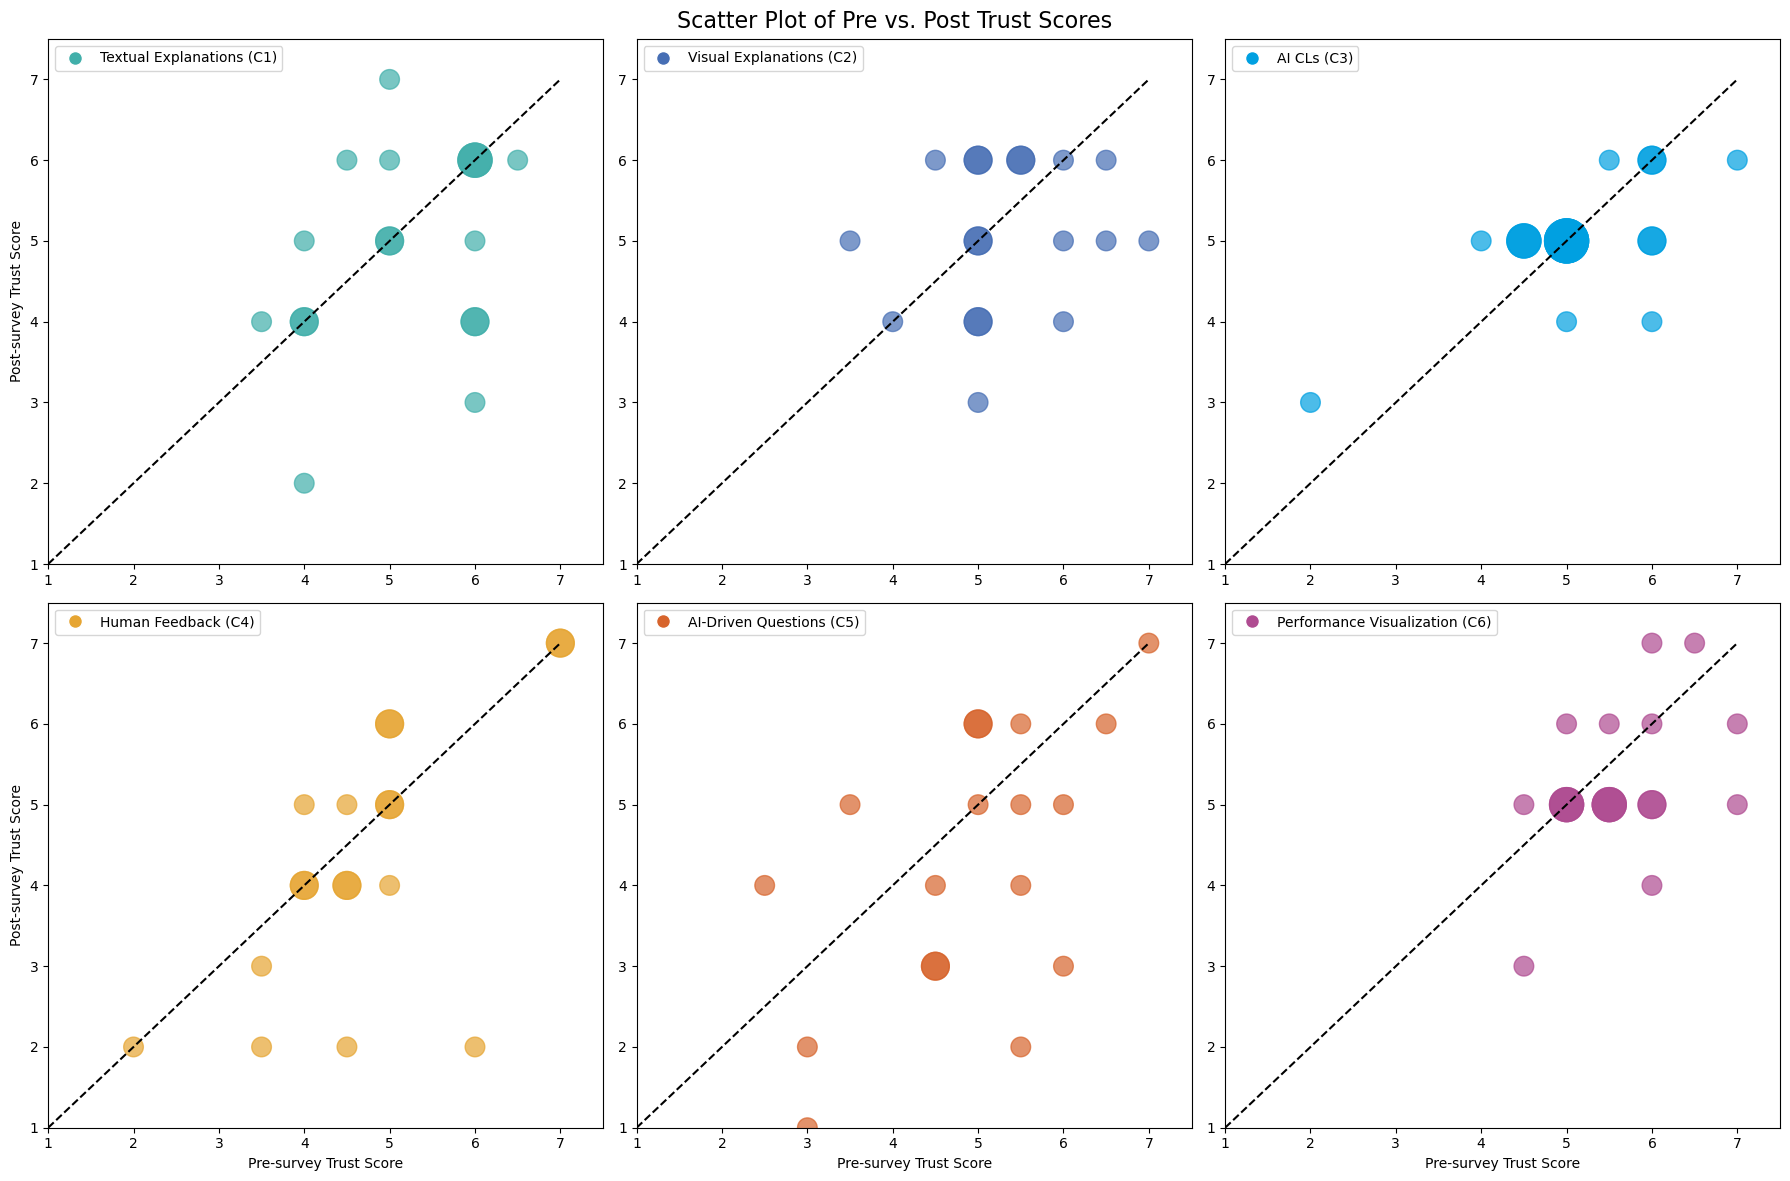

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.lines import Line2D

# Assuming load_data and CONDITION_MAP are defined
df = load_data()

survey = ['trust']
colors = ['#41afaa', '#466eb4', '#00a0e1', '#e6a532', '#d7642c', '#af4b91']

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
buffer = 0.5  # Space beyond the limit
xlim = (1, 7 + buffer)
ylim = (1, 7 + buffer)
all_scores = np.array([])

for i in range(1, 7):
    temp = df[df['condition'] == i]
    pre_scores = np.array([])
    post_scores = np.array([])

    for _, row in temp.iterrows():
        prescore = (row['pre_trust'] + row['pre_accurate']) / 2
        postscore = row['post_trust']
        pre_scores = np.append(pre_scores, prescore)
        post_scores = np.append(post_scores, postscore)

    all_scores = np.append(all_scores, pre_scores)
    all_scores = np.append(all_scores, post_scores)

    data_pairs = list(zip(pre_scores, post_scores))
    counts = Counter(data_pairs)
    sizes = [counts[point] * 200 for point in data_pairs]  # Scale size

    # Get the subplot for this condition
    ax = axes[(i - 1) // 3, (i - 1) % 3]
    ax.scatter(pre_scores, post_scores, s=sizes, alpha=0.7, color=colors[i - 1])
    ax.plot([1, 7], [1, 7], color='black', linestyle='--')
    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(range(1, 8))  # Show ticks only up to 7
    ax.set_yticks(range(1, 8))

    # Add labels for axes only for the leftmost and bottom subplots
    if (i - 1) % 3 == 0:
        ax.set_ylabel('Post-survey Trust Score')
    if i > 3:
        ax.set_xlabel('Pre-survey Trust Score')

    # Add a legend for this subplot
    ax.legend(
        [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i - 1], markersize=10)],
        [f'{CONDITION_MAP[int(i)]}'],
        loc='upper left',
    )

# Set a single title for the entire figure
fig.suptitle('Scatter Plot of Pre vs. Post Trust Scores', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
# plt.show()

plt.tight_layout()  # Ensures no clipping of elements
plt.savefig("pre_post_trust.svg")